In [2]:
import pickle 
import matplotlib.pyplot as plt


dict_keys(['train_loss', 'train_adj_loss', 'val_loss', 'val_adj_loss', 'train_r2', 'val_r2', 'best_params', 'final_params'])


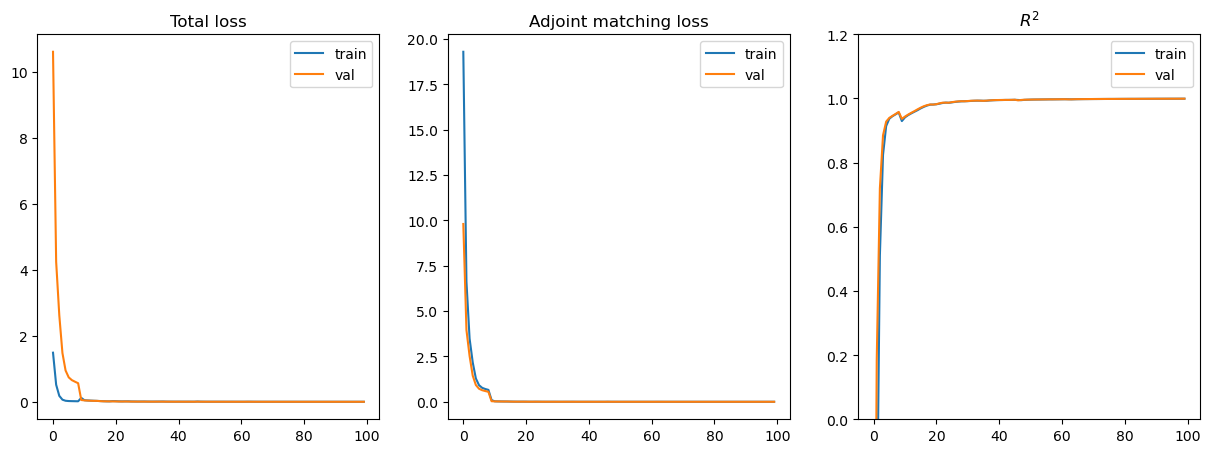

In [7]:
with open('./logs/logger_06-15-09_AdjointMatchingNN_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)

print(logger.keys())

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(logger['train_loss'], label='train')
ax[0].plot(logger['val_loss'], label='val')
ax[1].plot(logger['train_adj_loss'], label='train')
ax[1].plot(logger['val_adj_loss'], label='val')
ax[2].plot(logger['train_r2'], label='train')
ax[2].plot(logger['val_r2'], label='val')
ax[2].set_ylim(0,1.2)
ax[0].set_title('Total loss')
ax[1].set_title('Adjoint matching loss')
ax[2].set_title(r'$R^2$')
for a in ax:
    a.legend()
fig.savefig('burgersVJPtrain.pdf', format='pdf')
plt.show()

# Compare the adjoint of the NN (trained) and forward solver

In [47]:
from adjoint_matching import *
from scipy import linalg


net = FNN(num_layers=10, hidden_dim=200, output_dim=128, act_fn='tanh')
net.load_weights('./figs_adjoint/model/weights_mixed_init')
sup = AdjointMatchTrainer(net=net, data_path='./Data/mixed_init_cond/', save_name=None)
test = sup.prepare_data('test')
pred = net(test['x']).numpy()
pred_adj = sup.obtain_adjoint(test['x']).numpy()
true = test['y'].numpy()
true_adj = test['adj'].numpy()

print(true.shape, pred.shape)
print(test['x'].shape)

# diff = true_adj - pred_adj
# diff_sol = true - pred
# print(linalg.norm(diff))
# print(linalg.norm(diff_sol))


['sol_adj_coef_0.5pi.pkl']
(200, 128) (200, 128)
(200, 128)


In [1]:
from VJPMatching import MLP, Trainer
from AdjointMatchingNN.utils.data import split_data, combine_burgers_data
from AdjointMatchingNN.utils.metrics import mean_squared_error, r2
from AdjointMatchingNN.utils.scaler import StandardScaler
import pickle
import optax
import numpy as np
from jax import vmap

# config.update("jax_enable_x64", True)

# data = np.load('../data/vary_beta.dat_4-7-23.npz')
# inputs = data['inputs']
# uout = data['uout']
# j_beta = data['jac_beta']
# jrav = data['jac_u']
# jrav = np.concatenate([jrav, j_beta[..., np.newaxis]], axis=-1)

def vect_jcob_prod(v, jcob):
            return (
                v @ jcob
            )  # change the dimension to obtain the proper product

        

true_vjp = vmap(vect_jcob_prod, in_axes=0, out_axes=0)




x, y, adj = combine_burgers_data("./AdjointMatchingNN//Data/mixed_nu/")
train, val, test = split_data(x, y, adj, shuffle_all=True)

scaler = StandardScaler(train["x"])

net = MLP(
    [200] * 10,
    in_dim=train["x"].shape[1],
    out_dim=train["y"].shape[1],
    act_fn="tanh",
    scaler=scaler,
)
# sup = Trainer(
#     net=net,
#     num_epochs=args.epoch,
#     batch_size=args.batch_size,
#     learning_rate=args.lr,
#     optimizer=optax.adam,
#     if_full_Jacobian="False",
# )

with open('./logs/logger_06-15-09_AdjointMatchingNN_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)


train, val, test = split_data(x, y, adj, shuffle_all=True)
scaler = StandardScaler(train['x'])
x = test['x']
net = MLP([200]*5, in_dim=train['x'].shape[1], out_dim=train['y'].shape[1], act_fn='tanh', scaler=scaler)

params = logger['final_params']
test_pred = net.apply(params, x)

# test_pred = y_scaler.inverse_transform(test_pred)
v = test_pred - test['y']
# pred_adj = net.full_Jacobian(params, x)
pred_adj = net.nn_adjoint(params, x, v)
true_adj = true_vjp(v, test['adj'])
# pred_adj = adj_scaler.inverse_transform(pred_adj)

u_pred = net.apply(params, x)
# u_pred = y_scaler.inverse_transform(u_pred)


print('The test MSE is {:.4f}'.format(mean_squared_error(test['y'], test_pred)))
# print('The train MSE is {:.4f}'.format(mean_squared_error(train['y'], u_pred)))
print('The test R2 is {:.4f}'.format(r2(test['y'], test_pred)))
print('The test adj mse is {:.4f}'.format(mean_squared_error(true_adj, pred_adj)))
print('The test adj R2 is {:4f}'.format(r2(true_adj, pred_adj)))


: 

: 

In [66]:
# the plotter
import matplotlib.pyplot as plt
from matplotlib import animation

class Plotter:
    def __init__(self, data) -> None:
        
        # make the plot setting.
        # data -> a dict with keys 'pred', 'true'. 
        self.data = data
    def sol_plots(self, figsize, dpi=300):
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=figsize)
        ax1.imshow(self.data['true'].T, interpolation='nearest',
                    cmap='rainbow',
                    extent=[0, 1, -1, 1],
                    origin='lower', aspect='auto')
        ax2.imshow(self.data['pred'].T, interpolation='nearest',
                    cmap='rainbow',
                    extent=[0, 1, -1, 1],
                    origin='lower', aspect='auto')
        ax1.set_title('true')
        ax2.set_title('predicted')
        t = np.linspace(0, 1, self.data['true'].shape[0])
        x = np.linspace(-1, 1, self.data['true'].shape[1])
        frames = []
        for i in range(self.data['true'].shape[0]):
            im, = ax3.plot(x, self.data['true'].T[:, i], label='true', color='blue')
            im2, = ax3.plot(x, self.data['pred'].T[:, i], label='pred', color='red')
            im3 = ax3.text(0.7, 0.6, 't = %.3f' % t[i], transform=ax3.transAxes)
            frames.append([im, im2, im3])
        ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
        writergif = animation.PillowWriter(fps=15)
        ani.save('filename.gif',writer=writergif)

        # ax3.plot(self.data['true'].T[:,0])
        # ax3.plot(self.data['true'].T[:,5])
        # ax3.plot(self.data['true'].T[:,10])
        # ax3.plot(self.data['true'].T[:,15])
        # ax3.plot(self.data['true'].T[:,-1])

    def adj_plots(self):
        pass
        
        

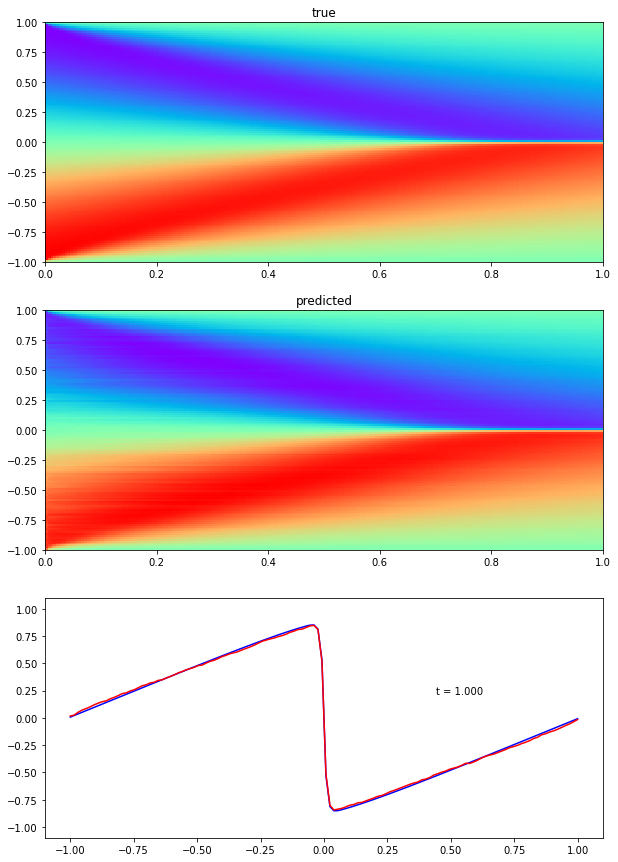

In [67]:
data = {'pred': pred, 'true': true}
plotter = Plotter(data)
plotter.sol_plots((10, 15))

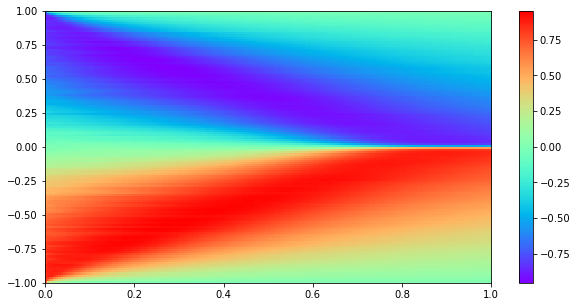

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.imshow(pred.T, interpolation='nearest',
                    cmap='rainbow',
                    extent=[0, 1, -1, 1],
                    origin='lower', aspect='auto')
plt.colorbar()
# plt.savefig('./figs_adjoint/pred_nu0.01-pi-adj.pdf', format='pdf')
plt.show()

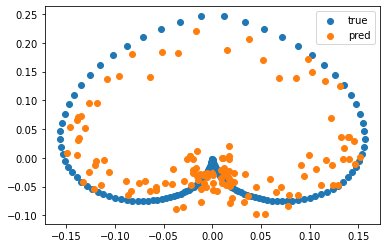

In [73]:
# vis adjoints
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
a = pca.fit_transform(true_adj[3])
b = pca.transform(pred_adj[3])

fig, ax = plt.subplots()
ax.scatter(a[:,0], a[:, 1], label='true')
ax.scatter(b[:, 0], b[:,1], label='pred')
# ax.imshow(pred_adj[0], cmap='rainbow')
plt.legend()
fig.savefig('./figs_adjoint/adj_nu0.5-pi-adj.pdf', format='pdf')


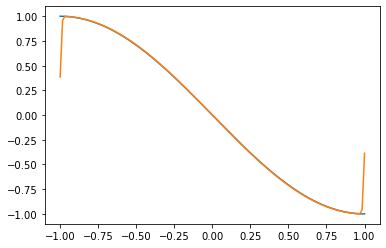

In [72]:
x = np.linspace(-1, 1, 128)
y = -np.sin(.5*np.pi*x)

plt.plot(x, y)
plt.plot(x,data['true'].T[:,0])